# 10 图像分割

图像分割 (segmentation) 分离出图像的前景 (foreground) 和背景 (background). 或者更多类的前景与背景.


曾经的非深度学习的图像分割方法有: K类均值, 高斯混合模型, 最小割,.....

## K 类均值

(K-means) 将图像所有像素归为 $k$ 个类 $\Omega_i\ (i=1,2,\dotsc,k)$, 使得整体的类内方差最小:
$$\mathcal L = \sum_{i=1}^k \sum_{x_j\in \Omega_i}\left(x_j - \mu_i\right)^2$$
其中 $\mu_i = \frac{1}{|\Omega_i|}\sum_{x_j \in \Omega_i}x_j$ 是第 $i$ 类像素值的平均值.

**定理**
$${\rm argmin}_\Omega \mathcal L = {\rm argmax}_\Omega \sum_{i=1}^k |\Omega_i|\mu_i^2 $$


**证明**
$$\begin{aligned}\mathcal L = \sum_{i=1}^k \sum_{x_j\in \Omega_i}\left(x_j - \mu_i\right)^2
= \sum_{i=1}^k \sum_{x_j\in \Omega_i}\left(x_j^2 - 2x_j\mu_i+\mu_i^2\right)
= \sum x_j^2 - \sum_{i=1}^k |\Omega_i|\mu_i^2
\end{aligned}
$$

<br>


**定理** 当 $K = 2$, 它等价于图像二值化的大津算法 (OTSU).

**证明** 由拉格朗日恒等式,
$$(|\Omega_1|+|\Omega_2|)(|\Omega_1|\mu_1^2+|\Omega_2|\mu_2^2)
=(|\Omega_1|\mu_1+|\Omega_2|\mu_2)^2+|\Omega_1||\Omega_2|(\mu_1 - \mu_2)^2$$
由于前一项是定值, 所以等价于最大化后一项, 即大津算法.

### 迭代法

类似大津算法精确求解复杂度太高. 可以用迭代法: 先随机初始化 $K$ 个类的均值, 然后将每个点划分到最近的一类, 计算新的划分的每一类的均值. 如此重复直到收敛.


### 缺点

K 均值算法没有考虑图片中像素点的位置, 且单个像素的分类易受噪声干扰.

In [111]:
from tqdm import tqdm
import numpy as np
def KMeans(X, k, iter = 6, centers = None):
    """Apply K-means on `X` with shape (N, p) where `k` is number of classes."""
    if centers is None:
        # equispaced initialization
        centers = np.linspace(np.min(X, axis = 0), np.max(X, axis = 0), k + 2)[1:-1]

    # tile X to shape (N, k, p), centers to shape (1, k, p)
    X_ = np.tile(X.reshape((X.shape[0], 1, -1)), [1, k, 1])
    centers = centers.reshape((1, k, -1))
    for i in tqdm(range(iter)):
        # classify to the nearest center
        classes = np.argmin(np.linalg.norm(X_ - centers, axis = -1), axis = 1)

        # update new centers
        for c in range(k):
            same = (classes == c).reshape((-1, 1))
            centers[0, c] = (same * X).sum(axis = 0) / same.sum(axis = 0)
    # print(centers)
    return classes

def OTSU(img):
    cdf = lambda x: np.array([np.sum(x <= i) for i in range(256)]) / x.size
    c = cdf(img)
    e = np.cumsum(np.arange(256) * np.diff(c, prepend = 0)) # cummulative expectance
    c = np.clip(c, 1e-8, 1 - 1e-8) # avoid division by 0
    
    # total_v = c * (1 - c) * np.square(e / c - (e[-1] - e) / (1 - c))
    total_v = np.square(e - c * e[-1]) / (c * (1 - c)) # same as the previous line
    total_v = np.log(total_v)
    return np.argmax(total_v)

100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


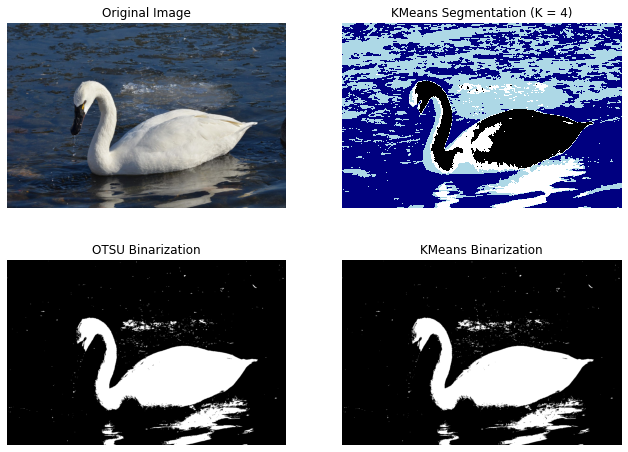

In [113]:
import os
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image 

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\swan.png')).convert('RGB')).astype('float')
img_bin = np.array(Image.fromarray(img.astype('uint8')).convert('L'))
img_shape = img.shape

segmentation_class = 4
# np.random.seed(2022)
# treat the RGB image as (H*W, 3) data matrix
classes = KMeans(img.reshape((-1, 3)), k = segmentation_class).reshape(img_shape[:-1])

# K-means for binarization
class_bin = KMeans(img.reshape((-1, 3)), k = 2).reshape(img.shape[:-1])

# OTSU binarzation (for comparison)
class_OTSU = img_bin > OTSU(img_bin.flatten())

plt.figure(figsize = (11, 8))
for i, title in zip(range(1, 5), ('Original Image', 'KMeans Segmentation (K = %d)'%segmentation_class,
                             'OTSU Binarization',  'KMeans Binarization')):
    plt.subplot(2, 2, i)
    if   i == 1: plt.imshow(img.astype('uint8'))
    elif i == 2: plt.imshow(classes, cmap = ListedColormap(["navy", "lightblue", "white", "black"]))
    elif i == 3: plt.imshow(class_OTSU, cmap = 'gray')
    elif i == 4: plt.imshow(class_bin, cmap = 'gray')
    plt.axis('off')
    plt.title(title)
plt.show()

In [119]:
# Verify OTSU and 2-Means are (almost) equivalent
print('Difference Between OTSU and KMeans Binarization = %.2f%%'%( 100. * \
    min((class_bin != class_OTSU).mean(), (class_bin == class_OTSU).mean())))

Difference Between OTSU and KMeans Binarization = 0.19%


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


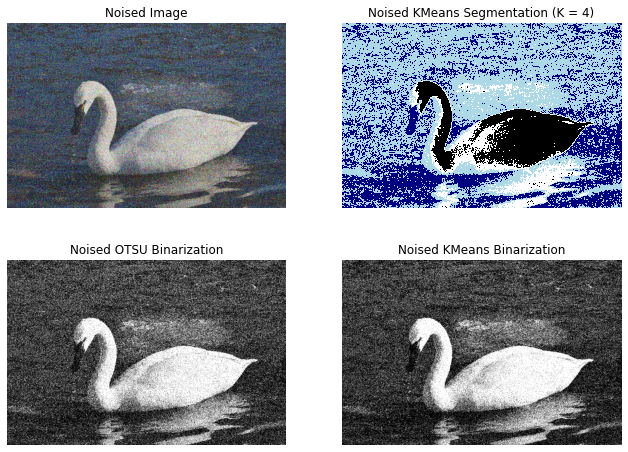

In [128]:
# noised image
import os
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image 

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\swan.png')).convert('RGB'))
np.random.seed(0)
img = np.clip(img.astype('float') + (np.random.randn(*img.shape)) * 100, 0, 255)
img_bin = np.array(Image.fromarray(img.astype('uint8')).convert('L'))
img_shape = img.shape

segmentation_class = 4
# np.random.seed(2022)
# treat the RGB image as (H*W, 3) data matrix
classes = KMeans(img.reshape((-1, 3)), k = segmentation_class).reshape(img_shape[:-1])

# K-means for binarization
class_bin = KMeans(img.reshape((-1, 3)), k = 2).reshape(img.shape[:-1])

# OTSU binarzation (for comparison)
class_OTSU = img_bin > OTSU(img_bin.flatten())

plt.figure(figsize = (11, 8))
for i, title in zip(range(1, 5), ('Image', 'KMeans Segmentation (K = %d)'%segmentation_class,
                             'OTSU Binarization',  'KMeans Binarization')):
    plt.subplot(2, 2, i)
    if   i == 1: plt.imshow(img.astype('uint8'))
    elif i == 2: plt.imshow(classes, cmap = ListedColormap(["navy", "lightblue", "white", "black"]))
    elif i == 3: plt.imshow(class_OTSU, cmap = 'gray')
    elif i == 4: plt.imshow(class_bin, cmap = 'gray')
    plt.axis('off')
    plt.title('Noised ' + title)
plt.show()

## 高斯混合模型

高斯混合模型 (Gaussian Mixture Model, GMM) 假设观测 (observation / response) $x$ 的概率密度由下式给出:
$$f(x|\alpha,\mu,\sigma^2) = \sum_{k=1}^K \alpha_k \cdot \frac{1}{\sqrt{2\pi \sigma_k^2}}\exp\left\{-\frac{(x - \mu_k)^2}{2\sigma_k^2}\right\}.$$

其中 $\mu_k,\sigma_k^2$ 为各个高斯分布的参数, $\sum_{k=1}^K \alpha_k = 1$ 为权重. 若假设 $\tilde k$ 是取值为 $1,2,\dotsc,K$ 概率分别为 $\alpha_1,\dotsc,\alpha_K$ 的离散概率分布, 那么易见
$$f(x) = \mathbb E_{\tilde k}(f(x| \mu_{\tilde k},\sigma_{\tilde k}^2)|\tilde k)$$

即 $x$ 相当于先按概率分布 $\alpha$ 中抽取一个高斯分布 $N(\mu_k,\sigma_k^2)$, 再根据该高斯分布采样.

### EM 算法

EM 算法用于迭代求解高斯混合模型的参数 $\alpha,\mu,\sigma^2$: 记 $\phi(y|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{1}{2\sigma^2}(y - \mu)^2\right\}$.

先初始化 $\alpha,\mu,\sigma^2$, 然后重复以下 E 与 M 步骤:

E: 计算
$$\gamma_{ik} = \frac{\alpha_k \phi(y_i|\mu_k,\sigma_k^2)}{\sum_{j=1}^K \alpha_j \phi(y_i|\mu_j,\sigma_j^2)}
$$

M: 更新
$$\sigma_k^2 \leftarrow \frac{\sum_{i=1}^n \gamma_{ik}(y_i - \mu_k)^2}{\sum_{i=1}^n \gamma_{ik}}\quad\quad\mu_k\leftarrow \frac{\sum_{i=1}^n \gamma_{ik}y_i}{\sum_{i=1}^n \gamma_{ik}}
\quad\quad \alpha_k \leftarrow \frac{\sum_{i=1}^n \gamma_{ik}}{n}$$

更多请见 <高级回归分析> 课程笔记.

In [35]:
from tqdm import tqdm
import numpy as np
class GMM():
    def __init__(self, mu = None, sigma = None, alpha = None):
        self.mu, self.sigma, self.alpha, self.K = mu, sigma, alpha, 1

    def EM(self, y, K = 1, iter = 20, prob = False):
        """EM Algorithm for GMM. `y` has shape (N, p). `K` is the number of classes."""
        # initialization
        y = y.reshape((y.shape[0], -1))
        N, p = y.shape
        self.K = K
        mu, sigma, alpha = self.mu, self.sigma, self.alpha
        if mu is None:
            mu = np.random.randn(K, p)
        if sigma is None:
            sigma = np.random.randn(K, p, p)
            sigma = np.matmul(sigma, np.transpose(sigma, (0, 2, 1))) # to Hermite
        if alpha is None:
            alpha = np.ones(K) / K
        
        # iteration
        for _ in tqdm(range(iter)):
            # E-step
            self.mu, self.sigma, self.alpha = mu, sigma, alpha
            gamma = self.predict(y, prob = True)

            # M-step
            centery = np.tile(y.reshape((N, 1, p, 1)), (1, K, 1, 1)) - mu.reshape((1, K, p, 1))
            centery = np.transpose(centery.reshape((N, K, p)), (1, 0, 2))
            s = np.sum(gamma, axis = 1)
            sigma = np.matmul(np.transpose(centery, (0, 2, 1)), gamma.reshape((K, N, 1)) * centery)
            sigma /= s.reshape((K, 1, 1))

            mu = gamma @ y / s.reshape((K, 1))

            alpha = s / N

        self.mu, self.sigma, self.alpha = mu, sigma, alpha

        if not prob:
            return np.argmax(gamma, axis = 0)
        return gamma

    def predict(self, y, prob = True):
        """Predict the class of `y` using GMM, P(z|y) = P(y,z) / P(y). Return shape (K, N)."""
        N, p = y.shape
        K = self.K
        mu, sigma, alpha = self.mu, self.sigma, self.alpha
        centery = np.tile(y.reshape((N, 1, p, 1)), (1, K, 1, 1)) - mu.reshape((1, K, p, 1))
        gamma = np.exp(-.5 * np.matmul(np.transpose(centery, (0, 1, 3, 2)), np.linalg.solve(sigma, centery)))
        coeff = (alpha / np.sqrt((2. * np.pi) ** p * np.linalg.det(sigma))).reshape((1, K))
        gamma = (coeff * gamma.reshape((N, K))).T # gamma shape: (K, N)
        gamma /= np.sum(gamma, axis = 0, keepdims = True)

        if not prob:
            return np.argmax(gamma, axis = 0)
        return gamma

100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


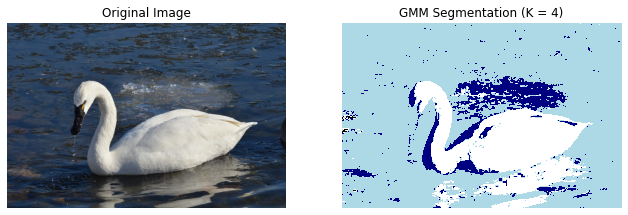

In [36]:
import os
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image 

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\swan.png')).convert('RGB'))
img_shape = img.shape

segmentation_class = 4
np.random.seed(2023)
gmm = GMM()
# standardlize the image is necessary before using GMM
classes = gmm.EM(img.reshape((-1, 3)) / 127.5 - 1., \
    K = segmentation_class, iter = 10).reshape(img_shape[:-1])

plt.figure(figsize = (11, 5))
for i, title in zip((1, 2), ('Original Image', 'GMM Segmentation (K = %d)'%segmentation_class)):
    plt.subplot(1, 2, i)
    if i == 1: plt.imshow(img)
    else:      plt.imshow(classes, cmap = ListedColormap(["navy", "lightblue", "white", "black"]))
    plt.axis('off')
    plt.title(title)
plt.show()